# GloVe 測試

In [2]:
# 載入相關套件
import numpy as np

# 載入GloVe詞向量檔 glove.6B.300d.txt
embeddings_dict = {}
with open("./glove/glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [3]:
# 隨意測試一個單字(love)，取得 GloVe 的詞向量
embeddings_dict['love']

array([-4.5205e-01, -3.3122e-01, -6.3607e-02,  2.8325e-02, -2.1372e-01,
        1.6839e-01, -1.7186e-02,  4.7309e-02, -5.2355e-02, -9.8706e-01,
        5.3762e-01, -2.6893e-01, -5.4294e-01,  7.2487e-02,  6.6193e-02,
       -2.1814e-01, -1.2113e-01, -2.8832e-01,  4.8161e-01,  6.9185e-01,
       -2.0022e-01,  1.0082e+00, -1.1865e-01,  5.8710e-01,  1.8482e-01,
        4.5799e-02, -1.7836e-02, -3.3952e-01,  2.9314e-01, -1.9951e-01,
       -1.8930e-01,  4.3267e-01, -6.3181e-01, -2.9510e-01, -1.0547e+00,
        1.8231e-01, -4.5040e-01, -2.7800e-01, -1.4021e-01,  3.6785e-02,
        2.6487e-01, -6.6712e-01, -1.5204e-01, -3.5001e-01,  4.0864e-01,
       -7.3615e-02,  6.7630e-01,  1.8274e-01, -4.1660e-02,  1.5014e-02,
        2.5216e-01, -1.0109e-01,  3.1915e-02, -1.1298e-01, -4.0147e-01,
        1.7274e-01,  1.8497e-03,  2.4456e-01,  6.8777e-01, -2.7019e-01,
        8.0728e-01, -5.8296e-02,  4.0550e-01,  3.9893e-01, -9.1688e-02,
       -5.2080e-01,  2.4570e-01,  6.3001e-02,  2.1421e-01,  3.31

In [4]:
# 字數
len(embeddings_dict.keys())

400000

## 尋找相似詞

In [5]:
# 以歐基里德(euclidean)距離計算相似性
from scipy.spatial.distance import euclidean

def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), 
                  key=lambda word: euclidean(embeddings_dict[word], embedding))

print(find_closest_embeddings(embeddings_dict["king"])[1:10])

['queen', 'monarch', 'prince', 'kingdom', 'reign', 'ii', 'iii', 'brother', 'crown']


## 以散佈圖觀察單字相似度

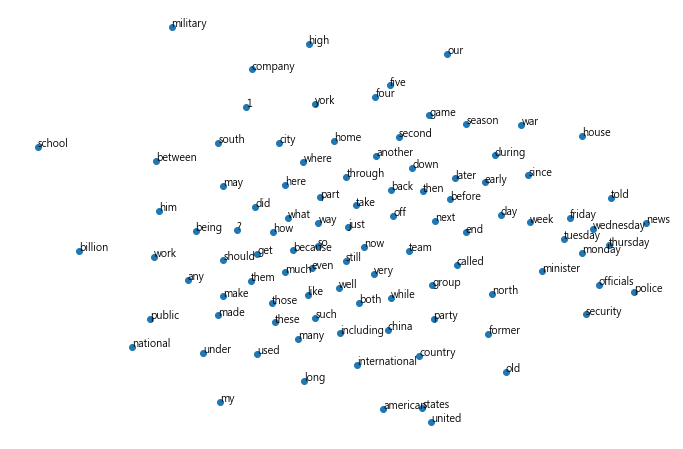

In [6]:
# 任意選 100 個單字
words =  list(embeddings_dict.keys())[100:200]
# print(words)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 以 T-SNE 降維至二個特徵
tsne = TSNE(n_components=2)
vectors = [embeddings_dict[word] for word in words]
Y = tsne.fit_transform(vectors)

# 繪製散佈圖，觀察單字相似度
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

## 文件相似度比較

In [7]:
# 測試語料：最後一句為問題，其他為回答
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

## 語料分詞

In [8]:
import nltk

# 參數設定
MAX_WORDS_A_LINE = 7  # 每行最多字數

# 分詞
document_tokens=[] # 整理後的字詞
token_count_per_line = [] # 每行字數
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # 篩選文數字(Alphanumeric)
for line in corpus:
    tokens = tokenizer.tokenize(line.lower())
    token_count_per_line.append(len(tokens))
    tokens += [''] * (MAX_WORDS_A_LINE - len(tokens))
    document_tokens.append(tokens)
    
document_tokens = np.array(document_tokens, dtype=object).reshape(len(corpus), -1)    
document_tokens.shape

(4, 7)

In [9]:
# 轉換詞向量
document_word_embeddings=np.zeros((len(corpus),MAX_WORDS_A_LINE,300))
for i in range(document_tokens.shape[0]):
    for j in range(document_tokens.shape[1]):
        if document_tokens[i, j] == '':
            continue
        document_word_embeddings[i, j] = embeddings_dict[document_tokens[i, j]]
    
document_word_embeddings.shape

(4, 7, 300)

In [10]:
token_count_per_line

[5, 6, 4, 5]

In [11]:
document_word_embeddings.shape[1]

7

## 使用 PV-DBOW (Paragraph Vector - Distributed Bag-of-words) 比較相似度

In [12]:
# 將同一句的每個單字詞向量平均
# 將補0的向量移除：先將之變為 nan，再使用 nanmean
for i in range(document_word_embeddings.shape[0]):
    document_word_embeddings[:, token_count_per_line[i]:, :] = np.nan
sum__word_embeddings = np.nanmean(document_word_embeddings, axis=1)
sum__word_embeddings.shape

(4, 300)

In [13]:
# 字句的相似度比較
from sklearn.metrics.pairwise import cosine_similarity
print (cosine_similarity(sum__word_embeddings[-1:], sum__word_embeddings[:-1], dense_output=False))

[[1.         0.98607379 0.88322124]]


## 結論：最後一句與第一句最相似